Computational Linguistics &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <br>Biao Yun

<center> 

# Basic Neural Network Assignment
### 2023.03.26

</center>

#### 引入所需 packages

In [1]:
from keras.preprocessing.text import Tokenizer
from nltk.util import bigrams
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Reshape
from keras.callbacks import Callback,ModelCheckpoint
import keras.backend as K
import pandas as pd
from keras.preprocessing.text import one_hot
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from ckiptagger import data_utils
import matplotlib.pyplot as plt

## (1) Run the word-word sequence langugage model again, and print out the f-score. (20%)

* 讀入英文檔案，此檔案為老師的示範檔案，這邊引入再跑一次同樣的流程，只是換成用 f-score 來評估模型
* 使用 Tokenizer 斷詞
* 此為 word-word sequence model，故目的為預測下一個字
* 在 word to word sequence 模型中，每個預測的字都是一個獨立的事件，因此可以把預測每個字的過程看作一個多類別分類問題。這種情況下單獨看 accuracy 可能不是那麼理想，因為 accuracy 無法反映不平衡類別之間的性能差異。例如，如果一個類別在 dataset 中的出現頻率很高，而另一個類別的出現頻率很低，那麼模型可能會傾向於將預測分配給出現頻率高的類別，而不是對兩個類別平等地考慮。不過這邊還是保留了 accuracy 的成績，提供更多參考資訊
* 因為 keras 套件中的 metrics 沒有 f-score 這個評估方式，所以需要另外定義一個自己的 f-score function，記錄參數並計算
* 每一個 epoch 都會計算當次的 macro f-score 分數，最後 model evalute 的 accuracy 和 f-score 則是所有 epoch 的平均
* f-score 是 precesion 和 recall 的加權調和平均數。它結合了 precesion 和 recall 的優點，同時考慮了 FP 和 FN，以綜合評估模型的準確性
* 使用 macro accuracy 和 macro f-score 則是因為用 macro 的方式能將所有資料視為同等重要，避免不平衡的狀況，因此更能全面地評估模型的性能。
* relu activation function: ReLU在正區間時，導數始終為 1，而 tanh 的導數最大只有 0.25，因此 ReLU 能夠更快地收斂；ReLU 計算速度更快，因為 ReLU 只需比較輸入是否大於0，而 tanh 需要進行指數計算。
* 畫出每次訓練的成績狀況，以便更直觀的了解模型性能

#### 讀入英文檔案

In [2]:
data = """ Jack and Jill went up the hill\n
        To fetch a pail of water\n
        Jack fell down and broke his crown\n
        And Jill came tumbling after\n """

#### 英文斷詞、製作 one-hot encodings

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]  # list within list

print(encoded)
print(tokenizer.word_index)

[2, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 14, 15, 1, 16, 17, 18, 1, 3, 19, 20, 21]
{'and': 1, 'jack': 2, 'jill': 3, 'went': 4, 'up': 5, 'the': 6, 'hill': 7, 'to': 8, 'fetch': 9, 'a': 10, 'pail': 11, 'of': 12, 'water': 13, 'fell': 14, 'down': 15, 'broke': 16, 'his': 17, 'crown': 18, 'came': 19, 'tumbling': 20, 'after': 21}


#### 計算 vocabulary size 及製作 bigrams

In [4]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 22


In [5]:
sequences = list()
for i in range(1, len(encoded)):
    sequence = encoded[i-1:i+1]
    sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
print(sequences)

Total Sequences: 24
[[2, 1], [1, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 2], [2, 14], [14, 15], [15, 1], [1, 16], [16, 17], [17, 18], [18, 1], [1, 3], [3, 19], [19, 20], [20, 21]]


In [6]:
sequences = np.array(sequences)
context_word, next_word = sequences[:,0],sequences[:,1]
context_word, next_word

(array([ 2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  2, 14, 15,  1,
        16, 17, 18,  1,  3, 19, 20]),
 array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  2, 14, 15,  1, 16,
        17, 18,  1,  3, 19, 20, 21]))

In [7]:
next_word = to_categorical(next_word, num_classes=vocab_size)
next_word

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

#### 定義 f-score function

In [8]:
def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 建構模型，引入定義好的 f-score function 做計算

In [9]:
model = Sequential()  # initialize a sequence model
model.add(Embedding(vocab_size, 10, input_length=1)) # initialize a embedding for features with 10 output_dim
model.add(Reshape((10,)))
model.add(Dense(units=50, activation='relu')) # one hidden layer with 50 output dimensions
model.add(Dense(vocab_size, activation='softmax')) # output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             220       
_________________________________________________________________
reshape (Reshape)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                550       
_________________________________________________________________
dense_1 (Dense)              (None, 22)                1122      
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
None


#### 模型訓練，共 50 個 epochs，列出每次的 accuracy 和 f-score

In [10]:
# fit network
eng = model.fit(context_word, next_word, epochs=50, verbose=2)  # you can specify batch size here

Epoch 1/50
1/1 - 11s - loss: 3.0974 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2/50
1/1 - 0s - loss: 3.0946 - accuracy: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 3/50
1/1 - 0s - loss: 3.0920 - accuracy: 0.0417 - f1_score: 0.0000e+00
Epoch 4/50
1/1 - 0s - loss: 3.0895 - accuracy: 0.0833 - f1_score: 0.0000e+00
Epoch 5/50
1/1 - 0s - loss: 3.0870 - accuracy: 0.0833 - f1_score: 0.0000e+00
Epoch 6/50
1/1 - 0s - loss: 3.0845 - accuracy: 0.1250 - f1_score: 0.0000e+00
Epoch 7/50
1/1 - 0s - loss: 3.0821 - accuracy: 0.1250 - f1_score: 0.0000e+00
Epoch 8/50
1/1 - 0s - loss: 3.0797 - accuracy: 0.1667 - f1_score: 0.0000e+00
Epoch 9/50
1/1 - 0s - loss: 3.0773 - accuracy: 0.1667 - f1_score: 0.0000e+00
Epoch 10/50
1/1 - 0s - loss: 3.0749 - accuracy: 0.1667 - f1_score: 0.0000e+00
Epoch 11/50
1/1 - 0s - loss: 3.0725 - accuracy: 0.1667 - f1_score: 0.0000e+00
Epoch 12/50
1/1 - 0s - loss: 3.0701 - accuracy: 0.1667 - f1_score: 0.0000e+00
Epoch 13/50
1/1 - 0s - loss: 3.0677 - accuracy: 0.1667 - f1_scor

#### 模型平均的 loss、accuracy 和 f-score

In [11]:
loss, accuracy, f1_score = model.evaluate(context_word, next_word, verbose=2)
print('Accuracy: %f' % (accuracy*100))
print('F1_score: %f' % (f1_score*100))
print('Loss: %d' % loss)

1/1 - 0s - loss: 2.9268 - accuracy: 0.3750 - f1_score: 0.0000e+00
Accuracy: 37.500000
F1_score: 0.000000
Loss: 2


#### 畫出每個 epoch 中 accuracy、f-score 和 loss 的成績

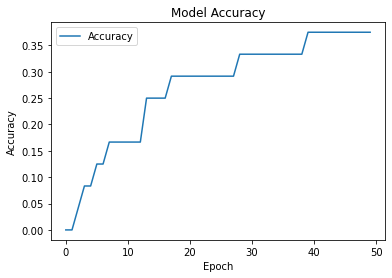

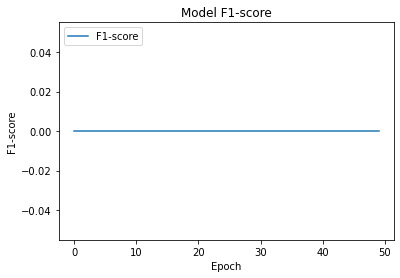

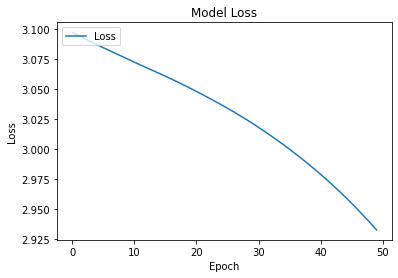

In [12]:


# plot accuracy
plt.plot(eng.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation'], loc='upper left')
plt.show()



# plot f1

plt.plot(eng.history['f1_score'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['F1-score', 'Validation'], loc='upper left')
plt.show()


# plot loss
plt.plot(eng.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

#### 嘗試讓模型預測下一個字

In [13]:
in_text = 'fetch'
print(in_text)
encoded = tokenizer.texts_to_sequences([in_text])[0]
encoded = np.array(encoded)
yhat = np.argmax(model.predict(encoded), axis=-1)
for word, index in tokenizer.word_index.items():
    if index == yhat:
        print(word)

fetch
a


## 第一題 Reflection

這邊發現因為英文資料實在是太小了，所以換成 f-score 評估時根本沒有用，數值接近 0。雖然觀察每次 epoch 的結果能發現 accuracy 有所增長，在 40 次 epoch 之後又上升了一些且達到穩定，loss 也慢慢下降，不過可能是資料太少，不同類別的樣本數量過少，模型預測能力差，以致於考慮更加全面的 f-score 沒有足夠的資料來評估模型（precision 和 recall 都很低），使最後 f-score 呈現接近 0 的情況。

## (2) Play around with the Chinese dataset yourself. Train a word-word or line-line sequence language model with 80% training set and 20% test set. (40%)

* 讀入中文文件
* 此檔案與上週檔案相同，為華語男歌手 2013-2023 之間發布之歌曲歌詞，包含歌手、歌名、歌詞、網址與日期等欄位，由魔鏡歌詞網取得
* 由於上週已經儲存好清理以及斷詞完的欄位`segmented_lyrics）`，所以這次會直接取用此欄位的資料來做 word-to-word sequence 模型
* 因為是 word-to-word sequence 模型，字數太多導致我的 kernel 無法負荷，故最終僅從原檔案取出 200 首歌的歌詞作為此次模型訓練資料
* 模型目的為預測下一個字是什麼
* 將資料 shuffle 之後分成 training and test set，確保資料是打散的狀態

#### 讀入中文文件

In [14]:

df_clean = pd.read_csv('/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Week_5/df_clean.csv', sep = '\t')
df_clean = df_clean.iloc[4225:4425]


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 4225 to 4424
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   singer            200 non-null    object
 1   name              200 non-null    object
 2   lyric             200 non-null    object
 3   song_url          200 non-null    object
 4   date              200 non-null    object
 5   sentiment         200 non-null    int64 
 6   segmented_lyrics  200 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.1+ KB


#### 選取 `segmented_lyrics` 欄位作為訓練資料

In [16]:
docs = list(df_clean['segmented_lyrics'])
docs_strings = ' '.join(docs)


#### 製作 one-hot encodings

In [17]:
tokenizer_zh = Tokenizer()
tokenizer_zh.fit_on_texts([docs_strings])
encoded_zh = tokenizer_zh.texts_to_sequences([docs_strings])[0]  # list within list

encoded_zh
tokenizer_zh.word_index

{'的': 1,
 '我': 2,
 '你': 3,
 '一': 4,
 '不': 5,
 '是': 6,
 '有': 7,
 '在': 8,
 '愛': 9,
 '著': 10,
 '了': 11,
 '會': 12,
 '也': 13,
 '這': 14,
 '妳': 15,
 '就': 16,
 '人': 17,
 '都': 18,
 '個': 19,
 '要': 20,
 '作詞': 21,
 '那': 22,
 '啊': 23,
 '還': 24,
 '想': 25,
 '作曲': 26,
 '沒': 27,
 '心': 28,
 '宅宅': 29,
 '讓': 30,
 '過': 31,
 '去': 32,
 '說': 33,
 '再': 34,
 '別': 35,
 '世界': 36,
 '來': 37,
 '為': 38,
 '天': 39,
 '誰': 40,
 '看': 41,
 '我們': 42,
 '感謝': 43,
 '中': 44,
 '又': 45,
 '每': 46,
 '他': 47,
 '夢': 48,
 '只': 49,
 '無': 50,
 '多': 51,
 '走': 52,
 '好': 53,
 '地': 54,
 '裡': 55,
 '什麼': 56,
 '被': 57,
 '對': 58,
 '自己': 59,
 '編曲': 60,
 '能': 61,
 '荒山亮': 62,
 '將': 63,
 '上': 64,
 '沒有': 65,
 '卻': 66,
 '與': 67,
 '吧': 68,
 '若': 69,
 '用': 70,
 '歌詞': 71,
 '到': 72,
 '當': 73,
 '華晨宇': 74,
 '和': 75,
 '像': 76,
 '步': 77,
 '所有': 78,
 '笑': 79,
 '永遠': 80,
 '路': 81,
 '幾': 82,
 '給': 83,
 '哪': 84,
 '咱': 85,
 '因為': 86,
 '做': 87,
 '離開': 88,
 '一切': 89,
 '愛愛': 90,
 '太多': 91,
 '可': 92,
 '幸福': 93,
 '知道': 94,
 '很': 95,
 '那些': 96,
 '它': 97,
 '過去': 98,
 '如

#### 計算 vocabulary size 並製作 bigrams

In [18]:
vocab_size_zh = len(tokenizer_zh.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_zh)

Vocabulary Size: 6636


In [19]:
sequences_zh = list(bigrams(encoded_zh))
sequences_zh

[(21, 4043),
 (4043, 4044),
 (4044, 26),
 (26, 4045),
 (4045, 1415),
 (1415, 2394),
 (2394, 13),
 (13, 108),
 (108, 1850),
 (1850, 376),
 (376, 1851),
 (1851, 2395),
 (2395, 727),
 (727, 105),
 (105, 51),
 (51, 2396),
 (2396, 376),
 (376, 847),
 (847, 6),
 (6, 2397),
 (2397, 5),
 (5, 640),
 (640, 2398),
 (2398, 2399),
 (2399, 2400),
 (2400, 358),
 (358, 48),
 (48, 4),
 (4, 113),
 (113, 533),
 (533, 2401),
 (2401, 641),
 (641, 52),
 (52, 1416),
 (1416, 376),
 (376, 109),
 (109, 1205),
 (1205, 52),
 (52, 1415),
 (1415, 441),
 (441, 2402),
 (2402, 2403),
 (2403, 4),
 (4, 77),
 (77, 4),
 (4, 231),
 (231, 2404),
 (2404, 728),
 (728, 1852),
 (1852, 2405),
 (2405, 182),
 (182, 729),
 (729, 2406),
 (2406, 7),
 (7, 17),
 (17, 67),
 (67, 15),
 (15, 2407),
 (2407, 848),
 (848, 7),
 (7, 17),
 (17, 442),
 (442, 15),
 (15, 2408),
 (2408, 92),
 (92, 2409),
 (2409, 7),
 (7, 17),
 (17, 67),
 (67, 15),
 (15, 2410),
 (2410, 2411),
 (2411, 7),
 (7, 17),
 (17, 321),
 (321, 15),
 (15, 1417),
 (1417, 1418),


In [20]:
sequences_zh = np.array(sequences_zh)
context_word_zh, next_word_zh = sequences_zh[:,0],sequences_zh[:,1]
context_word_zh, next_word_zh

(array([  21, 4043, 4044, ...,    3,   43,  112]),
 array([4043, 4044,   26, ...,   43,  112,   71]))

In [21]:
next_word_zh = to_categorical(next_word_zh, num_classes=vocab_size_zh)
next_word_zh

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### 將資料 shuffle 並分成 training and test sets

In [22]:


shuffled_contex, shuffled_next = shuffle(context_word_zh, next_word_zh, random_state = 888)
contex_train, contex_test, next_train, next_test = train_test_split(shuffled_contex, shuffled_next, test_size = 0.2, random_state = 413)




#### 定義 f-score function（不知道為什麼，如果我沒有在這裡重新定義一次，模型就會壞掉......）

In [23]:
def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 建構模型

In [24]:
model_zh = Sequential()  # initialize a sequence model
model_zh.add(Embedding(vocab_size_zh, 10, input_length=1)) # initialize a embedding for features with 10 output_dim
model_zh.add(Reshape((10,)))
model_zh.add(Dense(units=50, activation='relu')) # one hidden layer with 50 output dimensions
model_zh.add(Dense(vocab_size_zh, activation='softmax')) # output layer

model_zh.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

print(model_zh.summary())




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 10)             66360     
_________________________________________________________________
reshape_1 (Reshape)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 6636)              338436    
Total params: 405,346
Trainable params: 405,346
Non-trainable params: 0
_________________________________________________________________
None


## 第二題 Reflection

這邊我發現用我原本的檔案（vocabulary size 4 萬多），在分 training and test sets 那邊整個 kernel 就會自動結束，經過反覆測試之後發現約 2 萬字是電腦的極限（也可能是我的電腦太爛了，沒有足夠的記憶體😣）。

## (3) Print out the predicted Chinese result and evaluate with f-score. (20%)

* 進行模型訓練
* 設定 100 個 epochs
* 使用 f-score 評估模型，原因與第一題相同（同時保留 accuracy 的資訊）
* 算出 100 個 epochs 後的成績平均
* 畫出每次訓練模型的成績表現

#### 模型訓練，epochs = 100

In [25]:
zh = model_zh.fit(contex_train, next_train, epochs= 100, verbose=2)

Epoch 1/100
1103/1103 - 7s - loss: 7.4372 - accuracy: 0.0524 - f1_score: 0.0000e+00
Epoch 2/100
1103/1103 - 8s - loss: 6.8931 - accuracy: 0.0537 - f1_score: 0.0000e+00
Epoch 3/100
1103/1103 - 8s - loss: 6.6479 - accuracy: 0.0722 - f1_score: 0.0052
Epoch 4/100
1103/1103 - 9s - loss: 6.3565 - accuracy: 0.0939 - f1_score: 0.0186
Epoch 5/100
1103/1103 - 8s - loss: 6.0408 - accuracy: 0.1200 - f1_score: 0.0397
Epoch 6/100
1103/1103 - 8s - loss: 5.7091 - accuracy: 0.1458 - f1_score: 0.0610
Epoch 7/100
1103/1103 - 8s - loss: 5.3794 - accuracy: 0.1736 - f1_score: 0.0870
Epoch 8/100
1103/1103 - 7s - loss: 5.0566 - accuracy: 0.1986 - f1_score: 0.1158
Epoch 9/100
1103/1103 - 7s - loss: 4.7511 - accuracy: 0.2222 - f1_score: 0.1471
Epoch 10/100
1103/1103 - 7s - loss: 4.4794 - accuracy: 0.2466 - f1_score: 0.1737
Epoch 11/100
1103/1103 - 8s - loss: 4.2434 - accuracy: 0.2664 - f1_score: 0.1976
Epoch 12/100
1103/1103 - 8s - loss: 4.0415 - accuracy: 0.2832 - f1_score: 0.2187
Epoch 13/100
1103/1103 - 9s -

#### 計算平均成績

In [26]:
loss_zh, accuracy_zh, f1_score_zh = model_zh.evaluate(contex_test, next_test, verbose=2)
print('Accuracy: %f' % (accuracy_zh*100))
print('F1_score: %f' % (f1_score_zh*100))
print('Loss: %d' % loss_zh)

276/276 - 2s - loss: 11.4080 - accuracy: 0.2468 - f1_score: 0.2333
Accuracy: 24.676797
F1_score: 23.328128
Loss: 11


#### 畫出模型每個 epoch 的 accuracy、f-score 與 loss

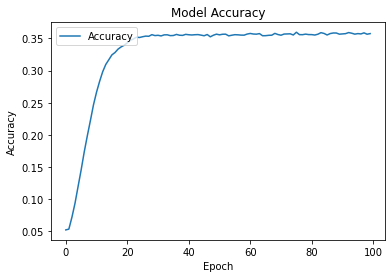

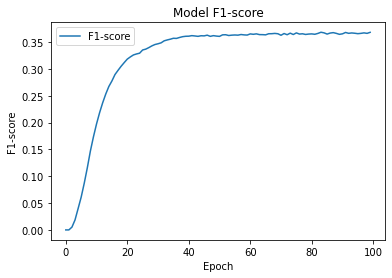

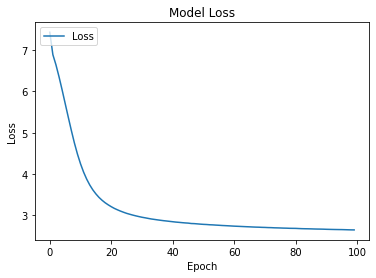

In [27]:


# plot accuracy
plt.plot(zh.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation'], loc='upper left')
plt.show()



# plot f1

plt.plot(zh.history['f1_score'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['F1-score', 'Validation'], loc='upper left')
plt.show()


# plot loss
plt.plot(zh.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

#### 讓模型預測下一個字

In [28]:
in_text = '我'
print(in_text)
encoded_zh_test = tokenizer_zh.texts_to_sequences([in_text])[0]
encoded_zh_test = np.array(encoded_zh_test)
yhat_zh = np.argmax(model_zh.predict(encoded_zh_test), axis=-1)
for word, index in tokenizer_zh.word_index.items():
    if index == yhat_zh:
        print(word)

我
的


## 第三題 Reflection

我原本用了 vocabulary size 約 2 萬的資料量去訓練，訓練結果非常不好，所以我又嘗試了各種不同類型的文本去訓練，以為文本應該要是同一篇文章，有連貫性，而非一篇一篇的歌詞，訓練結果才會比較好。經過多次測試，最終發現 vocabulary size 的影響應該是最大的，在 600 左右時無論是 accuracy 還是 f-score 成績都很不錯，然而增加到 2000 左右的時候就開始爛掉了（我這邊最後還是用了 6636 個字，因為其實沒辦法很確定到底是什麼原因）。雖然也不排除小文本的模型有 overfitting 的嫌疑，但我還是建議如果想要訓練更多東西，複雜一點的模型還是必須的😂

另外，對比英文版的超小 data 會發現，資料還是要有一定的大小與多次的 epochs 才能夠看出趨勢，包括在約 50 個 epochs 後穩定上升的 accuracy 和 f-score 以及穩定下降的 loss

## (4) Play around with batch size, and try to add a hidden layer with 50 units without using `Dense()`. Write out your notes or comments. (20%)

* batch size 為 64
* 因為題目規定不能使用 `Dense()` 作為隱藏層來添加神經元，所以這邊決定採用 LSTM 做隱藏層，因為它內部也可以設定添加神經元。
* 選擇 LSTM 是因為這種結構允許神經網路「記住」先前處理過的數據，並根據上下文訊息自適應地更新隱藏狀態，且理論上 LSTM 層更適合處理序列 data。
* 模型評估，方式與前一題一樣
* 繪製每個 epoch 的表現

#### 建構模型

In [29]:
model_zh_new = Sequential()  # initialize a sequence model
model_zh_new.add(Embedding(vocab_size_zh, 10, input_length=1)) # initialize a embedding for features with 10 output_dim
#model_zh_new.add(Reshape((10,)))
model_zh_new.add(LSTM(50, activation='relu')) # one hidden layer with 50 output dimensions
model_zh_new.add(Dense(vocab_size_zh, activation='softmax')) # output layer
model_zh_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

print(model_zh_new.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 10)             66360     
_________________________________________________________________
lstm (LSTM)                  (None, 50)                12200     
_________________________________________________________________
dense_4 (Dense)              (None, 6636)              338436    
Total params: 416,996
Trainable params: 416,996
Non-trainable params: 0
_________________________________________________________________
None


#### 設定 batch_size = 32

In [30]:
zh_new = model_zh_new.fit(contex_train, next_train, batch_size= 32, epochs= 100, verbose=2)

Epoch 1/100
1103/1103 - 16s - loss: 7.5201 - accuracy: 0.0524 - f1_score: 0.0000e+00
Epoch 2/100
1103/1103 - 8s - loss: 6.9595 - accuracy: 0.0528 - f1_score: 0.0000e+00
Epoch 3/100
1103/1103 - 8s - loss: 6.8715 - accuracy: 0.0528 - f1_score: 4.9452e-04
Epoch 4/100
1103/1103 - 8s - loss: 6.8163 - accuracy: 0.0528 - f1_score: 0.0020
Epoch 5/100
1103/1103 - 8s - loss: 6.7274 - accuracy: 0.0553 - f1_score: 0.0053
Epoch 6/100
1103/1103 - 8s - loss: 6.5886 - accuracy: 0.0693 - f1_score: 0.0175
Epoch 7/100
1103/1103 - 8s - loss: 6.4386 - accuracy: 0.0841 - f1_score: 0.0241
Epoch 8/100
1103/1103 - 9s - loss: 6.2817 - accuracy: 0.0952 - f1_score: 0.0348
Epoch 9/100
1103/1103 - 10s - loss: 6.0915 - accuracy: 0.1084 - f1_score: 0.0461
Epoch 10/100
1103/1103 - 8s - loss: 5.8283 - accuracy: 0.1349 - f1_score: 0.0645
Epoch 11/100
1103/1103 - 9s - loss: 5.5286 - accuracy: 0.1613 - f1_score: 0.0893
Epoch 12/100
1103/1103 - 11s - loss: 5.2455 - accuracy: 0.1807 - f1_score: 0.1127
Epoch 13/100
1103/1103

#### 計算平均成績

In [31]:
loss_zh_new, accuracy_zh_new, f1_score_zh_new = model_zh_new.evaluate(contex_test, next_test, verbose=2, batch_size = 32)
print('Accuracy: %f' % (accuracy_zh_new*100))
print('F1_score: %f' % (f1_score_zh_new*100))
print('Loss: %d' % loss_zh_new)

276/276 - 4s - loss: 12.2037 - accuracy: 0.2527 - f1_score: 0.2389
Accuracy: 25.266501
F1_score: 23.892270
Loss: 12


#### 繪製每個 epoch 的成績表現

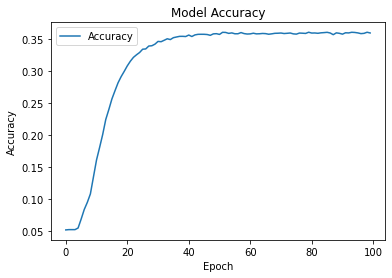

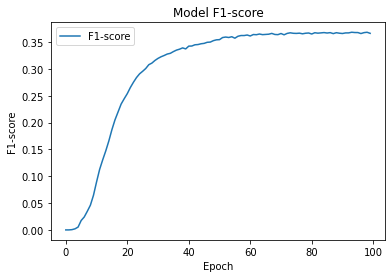

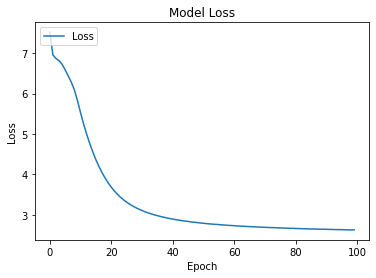

In [32]:
# import matplotlib.pyplot as plt


# plot accuracy
plt.plot(zh_new.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation'], loc='upper left')
plt.show()



# plot f1

plt.plot(zh_new.history['f1_score'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['F1-score', 'Validation'], loc='upper left')
plt.show()


# plot loss
plt.plot(zh_new.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

#### 讓模型預測下一個字

In [33]:
in_text = '銀河'
print(in_text)
encoded_zh_test = tokenizer_zh.texts_to_sequences([in_text])[0]
encoded_zh_test = np.array(encoded_zh_test)
yhat_zh = np.argmax(model_zh_new.predict(encoded_zh_test), axis=-1)
for word, index in tokenizer_zh.word_index.items():
    if index == yhat_zh:
        print(word)

銀河
盡頭


## 第四題 Reflection

這一題因為要調 batch size，所以我去查了相關資訊。

batch size 的選擇通常需要在模型訓練過程中進行嘗試和調整，以找到最適合的設置。
一般情況下，batch size 的選擇受以下因素的影響：
記憶體大小：較小的 batch size 可以讓模型在較小的記憶體中訓練，但是訓練時間可能會變長。
訓練集大小：如果訓練集很小，則可以選擇較大的 batch size 以利用更多的資料進行訓練。
模型複雜度：較複雜的模型可能需要使用較小的 batch size 以避免記憶體不足，同時較小的 batch size 也可以讓複雜的模型更穩定地收斂。
一般來說，batch size 的大小可以從 32、64、128 等值中進行嘗試，找到最適合當前模型和資料集的 batch size。如果在訓練過程中發現記憶體不足，可以降低 batch size；如果訓練時間過長，可以嘗試增加 batch size。

我的電腦真的在訓練時出現記憶體不足的狀況，且我的資料量不算特別大也沒有很小，同時考慮到讓模型穩定收斂，最終我選擇 batch size = 32 來做訓練。

另外，我其實滿驚訝 LSTM 的訓練結果沒有想像中好，雖然如果看最後一個 epoch 能發現比 `Dense()` 的高了一點點，可以忽略不計的那種一點點（Dense F1 = 0.3684 v.s. LSTM F1 = 0.3685），也許是我平常對它有太多很厲害的想像！？不過我猜是因為資料真的不算多，而且是 word-to-word 的預測，而非更長的句子，可能較無法展現 LSTM 的長處。也有可能是在深度學習中，模型的性能和複雜度之間通常存在著權衡。使用更複雜的模型可能會有好一點的性能，但是也可能存再過度擬合的風險（尤其是在 dataset 相對較小的情況下）。或者 LSTM 還有許多重要的參數我沒有慢慢調整，導致這次的訓練結果和用 `Dense()` 做 hidden layer 的結果相差無幾。

## 以下無聊想試試看 line-line sequence model

#### 讀取沒有被我拿掉標點符號的歌詞（後面比較好分行）

In [34]:

df_clean_new = pd.read_csv('/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Week_5/df_clean_new.csv', sep = '\t')
df_clean_new = df_clean_new.iloc[4225:4425]


In [35]:
docs = list(df_clean_new['segmented_lyrics'])
docs_strings = ' '.join(docs)


In [36]:
data = list(df_clean_new['lyric'])

In [37]:
data = ' '.join(data)

#### 斷句、one-hot encoding

In [38]:
tokenizer_line = Tokenizer()
tokenizer_line.fit_on_texts([docs_strings])


sequences_line = list()
for line in data.split(','):
    encoded_line = tokenizer_line.texts_to_sequences([line])[0]
    for i in range(1, len(encoded_line)):
        sequence = encoded_line[:i+1]
        sequences_line.append(sequence)
print('Total Sequences: %d' % len(sequences_line))
sequences_line

Total Sequences: 292


[[4365, 1916],
 [1461, 62],
 [456, 456],
 [456, 456],
 [456, 456],
 [766, 4440],
 [2587, 333],
 [2587, 2587],
 [2587, 2587],
 [4481, 4482],
 [1259, 4484],
 [62, 4573],
 [1270, 2671],
 [1270, 2671],
 [2033, 2034],
 [504, 333],
 [2806, 4446],
 [2806, 4446, 2807],
 [2806, 4446, 2807, 2808],
 [4782, 4784],
 [193, 4802],
 [1301, 62],
 [1300, 62],
 [2083, 2083],
 [4996, 2671],
 [496, 3048],
 [473, 473],
 [473, 473],
 [934, 757],
 [504, 333],
 [190, 3110],
 [1355, 477],
 [190, 436],
 [190, 436, 477],
 [1682, 477],
 [1355, 190],
 [190, 5405],
 [23, 1056],
 [23, 1056, 23],
 [23, 1056, 23, 1056],
 [23, 1056],
 [23, 1056, 23],
 [23, 1056, 23, 1056],
 [1029, 1029],
 [1029, 1029],
 [504, 333],
 [504, 3382],
 [504, 3382],
 [5622, 5624],
 [3443, 948],
 [3443, 948],
 [73, 3518],
 [73, 3518, 2034],
 [2814, 2090],
 [3947, 3947],
 [3947, 3947, 3947],
 [5803, 5804],
 [196, 5807],
 [196, 5807, 3378],
 [3947, 3947],
 [3947, 3947, 3947],
 [3947, 3947],
 [3947, 3947, 3947],
 [504, 333],
 [634, 3532],
 [634, 3

In [39]:
max_length = max([len(seq) for seq in sequences_line])
sequences = pad_sequences(sequences_line, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
print(sequences)

Max Sequence Length: 8
[[   0    0    0 ...    0 4365 1916]
 [   0    0    0 ...    0 1461   62]
 [   0    0    0 ...    0  456  456]
 ...
 [   0    0    0 ...    0 1204  418]
 [   0    0    0 ...    0 1204  418]
 [   0    0    0 ...    0 1204  418]]


In [40]:
sequences = np.array(sequences)
context_word_line, next_word_line = sequences[:,:-1],sequences[:,-1]

In [41]:
vocab_size_line = len(tokenizer_line.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_line)

Vocabulary Size: 6636


In [42]:
next_word_line = to_categorical(next_word_line, num_classes=vocab_size_line)

#### shuffle 後分 traing and test sets

In [43]:


shuffled_contex_l, shuffled_next_l = shuffle(context_word_line, next_word_line, random_state = 888)
contex_train_l, contex_test_l, next_train_l, next_test_l = train_test_split(shuffled_contex_l, shuffled_next_l, test_size = 0.2, random_state = 413)





#### 建構模型

In [44]:
model_line = Sequential()
model_line.add(Embedding(vocab_size_line, 10, input_length=max_length-1))
model_line.add(Reshape((70, )))
model_line.add(Dense(units=50, activation='relu')) # one hidden layer with 50 output dimensions
model_line.add(Dense(vocab_size_line, activation='softmax'))
print(model_line.summary())
# compile network
model_line.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 7, 10)             66360     
_________________________________________________________________
reshape_2 (Reshape)          (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_6 (Dense)              (None, 6636)              338436    
Total params: 408,346
Trainable params: 408,346
Non-trainable params: 0
_________________________________________________________________
None


#### 模型訓練

In [45]:
line = model_line.fit(contex_train_l, next_train_l, epochs=100, verbose=2)

Epoch 1/100
8/8 - 2s - loss: 8.7950 - accuracy: 0.0386 - f1_score: 0.0000e+00
Epoch 2/100
8/8 - 0s - loss: 8.7674 - accuracy: 0.0987 - f1_score: 0.0000e+00
Epoch 3/100
8/8 - 0s - loss: 8.7215 - accuracy: 0.1245 - f1_score: 0.0000e+00
Epoch 4/100
8/8 - 0s - loss: 8.6363 - accuracy: 0.1760 - f1_score: 0.0000e+00
Epoch 5/100
8/8 - 0s - loss: 8.4800 - accuracy: 0.1502 - f1_score: 0.0000e+00
Epoch 6/100
8/8 - 0s - loss: 8.2041 - accuracy: 0.1202 - f1_score: 0.0000e+00
Epoch 7/100
8/8 - 0s - loss: 7.7366 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 8/100
8/8 - 0s - loss: 7.0222 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 9/100
8/8 - 0s - loss: 6.0238 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 10/100
8/8 - 0s - loss: 4.9676 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 11/100
8/8 - 0s - loss: 4.3412 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 12/100
8/8 - 0s - loss: 4.1547 - accuracy: 0.0944 - f1_score: 0.0000e+00
Epoch 13/100
8/8 - 0s - loss: 4.1218 - accuracy: 0.0944 - f1_

#### 計算平均成績

In [46]:
loss_line, accuracy_line, f1_score_line = model_line.evaluate(contex_test_l, next_test_l, verbose=2)
print('Accuracy: %f' % (accuracy_line*100))
print('F1_score: %f' % (f1_score_line*100))
print('Loss: %d' % loss_line)

2/2 - 1s - loss: 7.8667 - accuracy: 0.4915 - f1_score: 0.5058
Accuracy: 49.152541
F1_score: 50.581390
Loss: 7


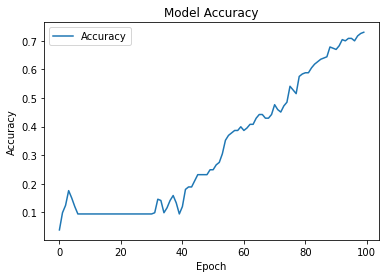

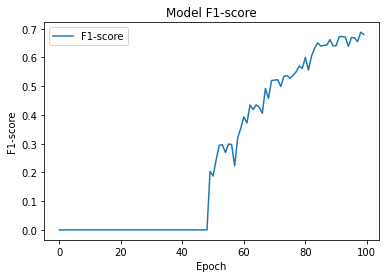

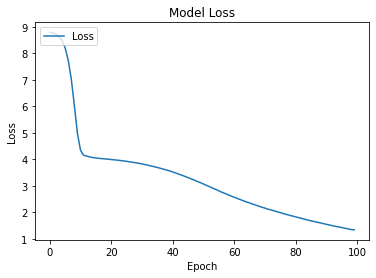

In [47]:


# plot accuracy
plt.plot(line.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation'], loc='upper left')
plt.show()



# plot f1

plt.plot(line.history['f1_score'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model F1-score')
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.legend(['F1-score', 'Validation'], loc='upper left')
plt.show()


# plot loss
plt.plot(line.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

#### 讓模型生出句子的 function

In [48]:
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # pre-pad sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        # predict probabilities for each word
        yhat = np.argmax(model.predict(encoded), axis=-1)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
    return in_text

#### 讓模型 generate 句子

In [49]:

print(generate_seq(model_line, tokenizer_line, max_length-1, '悲觀', 10))


悲觀 孤單 遺憾 不堪 感嘆 疲倦 輾轉 難安 主題曲 啊 放慢


## Reflection

我能說什麼呢......從訓練過程的圖（瘋狂竄動，看起來還沒找到它收斂的點）到生成的結果都很糟糕。不知道該說它學得好還是不好，有夠敷衍的 copy and paste 歌詞，還穿插奇怪的詞進去......對了，不管是 f-score 還是 accuracy 都比 word-to-word model 高，loss 也低很多。
但它真的好爛，嗚嗚嗚嗚嗚～～～（心態崩了）